Luis Manuel Gallegos Pérez A01659884

Damián Calderón Capallera A01661093

Daniela Martínez Xolalpa A01657901

Fernando Vázquez Rivera A01658933

José de Jesús Rodríguez Rocha A01664806



##  Predictive Hypothesis

In our last deliverable we mainly focused on the imporance of what type of crime tend to occur and if their violent and non violent. From that analysis er dicided to implement the following for the creation of our predictive model:
* fecha_hecho
* hora_hecho
* colonia_hecho
* alcaldia_hecho
* latitud
* longitud
* crime_classification
* violence_type
We decided to use these columns as they would enable us to archive the requirements of the training parter as well as to have enough information create a robust model.
For this we plan to use crime_classification as our target output while the rest we use as feature vectors. If at any point during

###  Models to use

##Packaing

In [1]:
import duckdb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans # <-- MEJORA 1 (Clustering)
from sklearn.metrics import classification_report
from scipy.stats import randint # <-- MEJORA 3 (Tuning)
import warnings
warnings.filterwarnings('ignore')

import re #Module to work with regular expressions

from google.colab import drive #Import tool to connect Google Drive

##Data Reading

In [2]:
drive.mount('/content/drive') #Mount Google Drive in Colab
path = '/content/drive/MyDrive/' #Main path in Google Drive
print(f'Files will be accessed from: {path}') #Print path where files will be accessed from
datos = pd.read_csv(path + 'cleaned_crime_data.csv') #Load CSV file into a pandas DataFrame

Mounted at /content/drive
Files will be accessed from: /content/drive/MyDrive/


## 2.2 Preprocessing

In [3]:
columns_to_select = [
    'hora_hecho',
    'mes_hecho',
    'fecha_hecho',
    'alcaldia_hecho',
    'crime_classification',
    'latitud',
    'longitud',
    'violence_type',
    'delito'
]

# Ensure 'fecha_hecho' in 'datos' is datetime for filtering
datos['fecha_hecho'] = pd.to_datetime(datos['fecha_hecho'])

# Filter 'datos' for dates between 2016 and 2024 first
filtered_datos_by_date = datos[(datos['fecha_hecho'] >= '2016-01-01') & (datos['fecha_hecho'] < '2025-01-01')]

# Now select columns without limiting the number of rows
df_filtered = filtered_datos_by_date[columns_to_select]

print("Null values before handling:\n", df_filtered.isnull().sum())

df_filtered.dropna(inplace=True)

print("\nNull values after handling:\n", df_filtered.isnull().sum())
print(f"\nShape of df_filtered after dropping nulls: {df_filtered.shape}")

display(df_filtered.head())

Null values before handling:
 hora_hecho               0
mes_hecho                0
fecha_hecho              0
alcaldia_hecho          10
crime_classification     0
latitud                  0
longitud                 0
violence_type            0
delito                   0
dtype: int64

Null values after handling:
 hora_hecho              0
mes_hecho               0
fecha_hecho             0
alcaldia_hecho          0
crime_classification    0
latitud                 0
longitud                0
violence_type           0
delito                  0
dtype: int64

Shape of df_filtered after dropping nulls: (1912235, 9)


,hora_hecho,mes_hecho,fecha_hecho,alcaldia_hecho,crime_classification,latitud,longitud,violence_type,delito
2,00:20:00,1,2016-01-01,IZTAPALAPA,Patrimony,19.34080,-99.11431,Violent,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA
9,01:45:00,1,2016-01-01,IZTAPALAPA,Life and Integrity,19.31861,-99.07572,Violent,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...
11,01:15:00,1,2016-01-01,MIGUEL HIDALGO,Patrimony,19.45716,-99.17253,Non-Violent,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL
14,01:30:00,1,2016-01-01,COYOACAN,Patrimony,19.31267,-99.11181,Violent,ROBO A CASA HABITACION SIN VIOLENCIA
15,02:00:00,1,2016-01-01,AZCAPOTZALCO,Patrimony,19.47936,-99.17994,Non-Violent,DAÑO EN PROPIEDAD AJENA INTENCIONAL A NEGOCIO


In [4]:
# Extract the date from 'fecha_hecho' and convert it to datetime objects
df_filtered['fecha'] = pd.to_datetime(df_filtered['fecha_hecho']).dt.date

# Group by the new 'fecha' column and count the number of 'delitos' for each day
daily_delitos_df = df_filtered.groupby('fecha').size().reset_index(name='delitos_count')

# Convert the 'fecha' column to datetime objects and set it as the DataFrame's index
daily_delitos_df['fecha'] = pd.to_datetime(daily_delitos_df['fecha'])
daily_delitos_df.set_index('fecha', inplace=True)

# Resample to a continuous daily frequency and fill any missing dates with 0
daily_delitos_df = daily_delitos_df.resample('D').sum().fillna(0).astype(int)

# Filter for dates between 2016 and 2024
daily_delitos_df = daily_delitos_df[(daily_delitos_df.index >= '2016-01-01') & (daily_delitos_df.index < '2025-01-01')]

print("Daily Delitos Count (2016-2024):")
display(daily_delitos_df.head())
display(daily_delitos_df.tail())
print(f"\nShape of daily_delitos_df: {daily_delitos_df.shape}")
print("\nData types of daily_delitos_df:")
print(daily_delitos_df.info())

Daily Delitos Count (2016-2024):


,delitos_count
fecha,
2016-01-01,555
2016-01-02,386
2016-01-03,366
2016-01-04,566
2016-01-05,515


,delitos_count
fecha,
2024-10-21,369
2024-10-22,405
2024-10-23,363
2024-10-24,297
2024-10-25,172



Shape of daily_delitos_df: (3221, 1)

Data types of daily_delitos_df:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3221 entries, 2016-01-01 to 2024-10-25
Freq: D
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   delitos_count  3221 non-null   int64
dtypes: int64(1)
memory usage: 50.3 KB
None


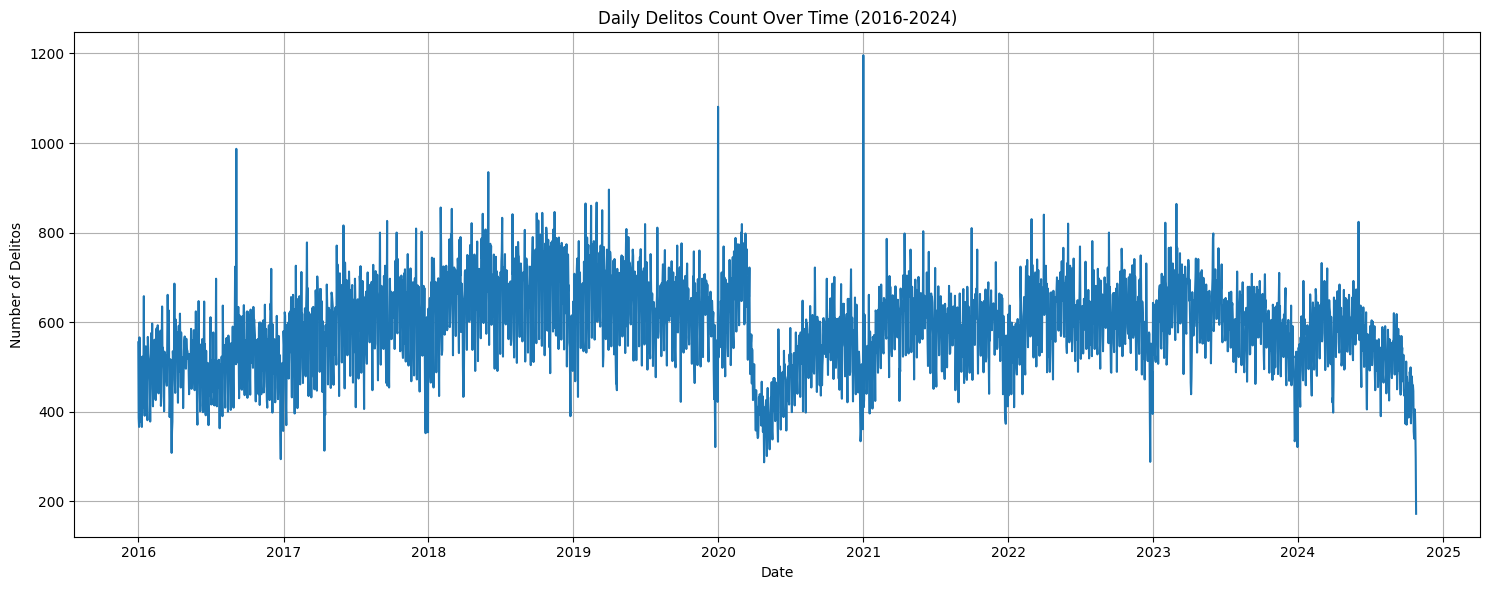

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.lineplot(data=daily_delitos_df, x=daily_delitos_df.index, y='delitos_count')
plt.title('Daily Delitos Count Over Time (2016-2024)')
plt.xlabel('Date')
plt.ylabel('Number of Delitos')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize df_processed with a copy of df_filtered to start
df_processed = df_filtered.copy()

# Ensure 'fecha_hecho' is datetime type again for feature extraction
df_processed['fecha_hecho'] = pd.to_datetime(df_processed['fecha_hecho'])

# Extract new time-based features
df_processed['day_of_week'] = df_processed['fecha_hecho'].dt.dayofweek # Monday=0, Sunday=6
df_processed['week_of_year'] = df_processed['fecha_hecho'].dt.isocalendar().week.astype(int) # Week number (1-52/53)
df_processed['is_even_week_of_year'] = (df_processed['week_of_year'] % 2 == 0).astype(int) # 1 if even, 0 if odd

# Define columns to label encode
cols_to_label_encode = ['violence_type', 'alcaldia_hecho', 'crime_classification']

# Apply Label Encoding to each specified column
le = LabelEncoder()
for col in cols_to_label_encode:
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    # Drop the original categorical column
    df_processed.drop(columns=[col], inplace=True)

# Display head and info of the new DataFrame
print("DataFrame after encoding and feature extraction:")
display(df_processed.head())
print("\nData types after encoding and feature extraction:")
df_processed.info()

DataFrame after encoding and feature extraction:


,hora_hecho,mes_hecho,fecha_hecho,latitud,longitud,delito,fecha,day_of_week,week_of_year,is_even_week_of_year,violence_type_encoded,alcaldia_hecho_encoded,crime_classification_encoded
2,00:20:00,1,2016-01-01,19.34080,-99.11431,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,2016-01-01,4,53,0,1,8,4
9,01:45:00,1,2016-01-01,19.31861,-99.07572,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,2016-01-01,4,53,0,1,8,2
11,01:15:00,1,2016-01-01,19.45716,-99.17253,DAÑO EN PROPIEDAD AJENA INTENCIONAL A AUTOMOVIL,2016-01-01,4,53,0,0,10,4
14,01:30:00,1,2016-01-01,19.31267,-99.11181,ROBO A CASA HABITACION SIN VIOLENCIA,2016-01-01,4,53,0,1,3,4
15,02:00:00,1,2016-01-01,19.47936,-99.17994,DAÑO EN PROPIEDAD AJENA INTENCIONAL A NEGOCIO,2016-01-01,4,53,0,0,1,4



Data types after encoding and feature extraction:
<class 'pandas.core.frame.DataFrame'>
Index: 1912235 entries, 2 to 1941651
Data columns (total 13 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   hora_hecho                    object        
 1   mes_hecho                     int64         
 2   fecha_hecho                   datetime64[ns]
 3   latitud                       float64       
 4   longitud                      float64       
 5   delito                        object        
 6   fecha                         object        
 7   day_of_week                   int32         
 8   week_of_year                  int64         
 9   is_even_week_of_year          int64         
 10  violence_type_encoded         int64         
 11  alcaldia_hecho_encoded        int64         
 12  crime_classification_encoded  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(6), object(3)
memory usage: 197.0+ M

In [7]:
y = df_processed['crime_classification_encoded']

# Exclude target and other non-feature columns from X
# 'delito' is the original crime name, 'fecha_hecho' and 'fecha' are datetime objects
# 'hora_hecho' and 'mes_hecho' are also original features that might have encoded versions or are not needed directly
# 'latitud' and 'longitud' are numerical features, but will be excluded for now to simplify the initial model.
features_to_exclude = [
    'crime_classification_encoded',
    'delito',
    'fecha_hecho',
    'fecha',
    'hora_hecho',
    'mes_hecho',
    'latitud',
    'longitud'
]

# Filter out only existing columns to exclude to prevent errors
features_to_exclude_exist = [col for col in features_to_exclude if col in df_processed.columns]

X = df_processed.drop(columns=features_to_exclude_exist)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train:")
display(X_train.head())
print("\nFirst 5 rows of y_train:")
display(y_train.head())

Shape of X_train: (1529788, 5)
Shape of X_test: (382447, 5)
Shape of y_train: (1529788,)
Shape of y_test: (382447,)

First 5 rows of X_train:


,day_of_week,week_of_year,is_even_week_of_year,violence_type_encoded,alcaldia_hecho_encoded
395216,3,9,0,1,6
463239,5,25,0,0,0
306853,1,38,1,0,8
1033692,6,30,1,0,6
180973,6,4,1,1,1



First 5 rows of y_train:


,crime_classification_encoded
395216,4
463239,4
306853,4
1033692,3
180973,4


## Splitting

In [8]:
df_processed = df_processed.sort_values(by='fecha_hecho', ascending=True)
print("DataFrame after sorting by 'fecha_hecho':")
display(df_processed.head())

DataFrame after sorting by 'fecha_hecho':


,hora_hecho,mes_hecho,fecha_hecho,latitud,longitud,delito,fecha,day_of_week,week_of_year,is_even_week_of_year,violence_type_encoded,alcaldia_hecho_encoded,crime_classification_encoded
2,00:20:00,1,2016-01-01,19.34080,-99.11431,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,2016-01-01,4,53,0,1,8,4
65797,12:00:00,1,2016-01-01,19.39052,-99.17345,DENUNCIA DE HECHOS,2016-01-01,4,53,0,0,2,3
66574,12:00:00,1,2016-01-01,19.35613,-99.09248,INSOLVENCIA ALIMENTARIA,2016-01-01,4,53,0,0,8,3
67867,12:00:00,1,2016-01-01,19.39544,-99.09279,AMENAZAS,2016-01-01,4,53,0,0,7,3
69887,12:00:00,1,2016-01-01,19.19980,-99.12196,DESPOJO,2016-01-01,4,53,0,0,15,4


In [11]:
# Re-define X and y from the already sorted df_processed to ensure correct time-based split
feature_columns = X.columns.tolist() # Define feature_columns based on the previously determined features
y = df_processed['crime_classification_encoded']
X = df_processed[feature_columns] # 'feature_columns' was defined previously

split_index = int(len(df_processed) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train:")
display(X_train.head())
print("\nFirst 5 rows of y_train:")
display(y_train.head())

Shape of X_train: (1529788, 5)
Shape of X_test: (382447, 5)
Shape of y_train: (1529788,)
Shape of y_test: (382447,)

First 5 rows of X_train:


,day_of_week,week_of_year,is_even_week_of_year,violence_type_encoded,alcaldia_hecho_encoded
2,4,53,0,1,8
65797,4,53,0,0,2
66574,4,53,0,0,8
67867,4,53,0,0,7
69887,4,53,0,0,15



First 5 rows of y_train:


,crime_classification_encoded
2,4
65797,3
66574,3
67867,3
69887,4


## Clustering

## Determining Optimal Number of Clusters (Elbow Method)

To find a more appropriate number of clusters for our 'hot zones', we will use the Elbow Method. This involves fitting KMeans for a range of `n_clusters` values and plotting the inertia (sum of squared distances of samples to their closest cluster center) for each `k`.

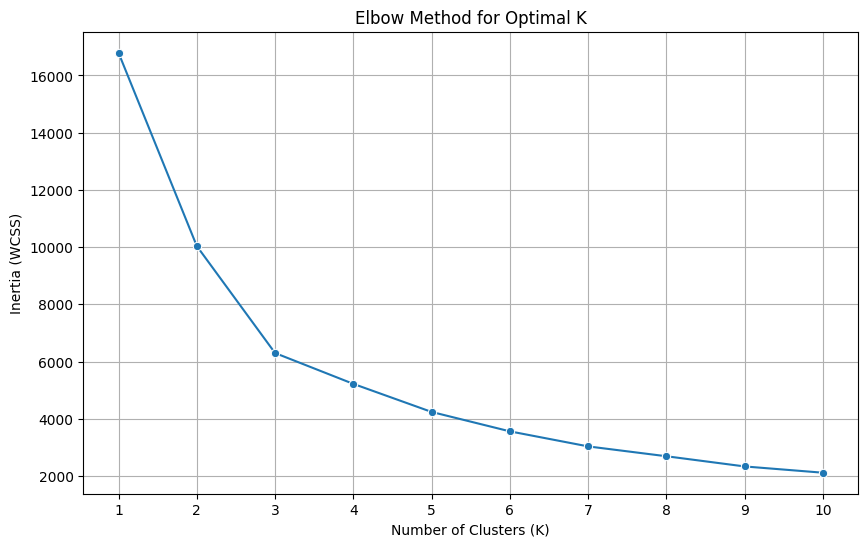

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Select latitude and longitude for clustering
coords = df_processed[['latitud', 'longitud']]

# List to store the inertia values for different k
inertia = []

# Range of k values to test
k_range = range(1, 11) # Testing from 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(k_range), y=inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

After reviewing the plot, you can identify the 'elbow' point where the decrease in inertia starts to slow down significantly. This point is often a good indicator of the optimal number of clusters.

## Clustering for Hot Zones

To identify crime 'hot zones', we will apply KMeans clustering to the latitude and longitude coordinates. Each cluster will represent a geographical area with a higher concentration of reported crimes. This new categorical feature can then be used in our predictive model.

In [19]:
# Select latitude and longitude for clustering
coords = df_processed[['latitud', 'longitud']]

# Initialize KMeans with 3 clusters based on the Elbow Method analysis
kmeans = KMeans(n_clusters=80, random_state=42, n_init='auto')

# Fit KMeans to the coordinates and get cluster labels
df_processed['hot_zone_cluster'] = kmeans.fit_predict(coords)

print("KMeans clustering applied with 3 clusters. Updated 'hot_zone_cluster' column added.")
print("Value counts for 'hot_zone_cluster':")
display(df_processed['hot_zone_cluster'].value_counts())

display(df_processed.head())

KMeans clustering applied with 3 clusters. Updated 'hot_zone_cluster' column added.
Value counts for 'hot_zone_cluster':


,count
hot_zone_cluster,
51,53879
17,51024
37,45139
5,43154
73,39653
...,...
45,7540
75,6507
35,5781


,hora_hecho,mes_hecho,fecha_hecho,latitud,longitud,delito,fecha,day_of_week,week_of_year,is_even_week_of_year,violence_type_encoded,alcaldia_hecho_encoded,crime_classification_encoded,hot_zone_cluster
2,00:20:00,1,2016-01-01,19.34080,-99.11431,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,2016-01-01,4,53,0,1,8,4,62
65797,12:00:00,1,2016-01-01,19.39052,-99.17345,DENUNCIA DE HECHOS,2016-01-01,4,53,0,0,2,3,24
66574,12:00:00,1,2016-01-01,19.35613,-99.09248,INSOLVENCIA ALIMENTARIA,2016-01-01,4,53,0,0,8,3,14
67867,12:00:00,1,2016-01-01,19.39544,-99.09279,AMENAZAS,2016-01-01,4,53,0,0,7,3,42
69887,12:00:00,1,2016-01-01,19.19980,-99.12196,DESPOJO,2016-01-01,4,53,0,0,15,4,36


In [22]:
import numpy as np

# 1. Extract numerical hour from 'hora_hecho'
df_processed['hour_hecho'] = pd.to_datetime(df_processed['hora_hecho'], format='%H:%M:%S').dt.hour

# 2. Apply sine and cosine transformations for cyclical features
# Month (1-12)
df_processed['mes_hecho_sin'] = np.sin(2 * np.pi * df_processed['mes_hecho'] / 12)
df_processed['mes_hecho_cos'] = np.cos(2 * np.pi * df_processed['mes_hecho'] / 12)

# Day of Week (0-6)
df_processed['day_of_week_sin'] = np.sin(2 * np.pi * df_processed['day_of_week'] / 7)
df_processed['day_of_week_cos'] = np.cos(2 * np.pi * df_processed['day_of_week'] / 7)

# Week of Year (1-53) - using 53 as max for isocalendar weeks
df_processed['week_of_year_sin'] = np.sin(2 * np.pi * df_processed['week_of_year'] / 53)
df_processed['week_of_year_cos'] = np.cos(2 * np.pi * df_processed['week_of_year'] / 53)

# Hour of Day (0-23)
df_processed['hour_hecho_sin'] = np.sin(2 * np.pi * df_processed['hour_hecho'] / 24)
df_processed['hour_hecho_cos'] = np.cos(2 * np.pi * df_processed['hour_hecho'] / 24)

# 3. Define the new set of feature columns, including the new cyclical features and hot_zone_cluster
# Exclude original cyclical features, and other non-feature columns
new_feature_columns = [
    'is_even_week_of_year',
    'violence_type_encoded',
    'alcaldia_hecho_encoded',
    'hot_zone_cluster',
    'mes_hecho_sin',
    'mes_hecho_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'hour_hecho_sin',
    'hour_hecho_cos'
]

# Ensure all new_feature_columns actually exist in df_processed
feature_columns = [col for col in new_feature_columns if col in df_processed.columns]

# 4. Re-define X and y from the already sorted df_processed
y = df_processed['crime_classification_encoded']
X = df_processed[feature_columns]

# 5. Re-split data into training and testing sets based on the time-based split
split_index = int(len(df_processed) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print("Cyclical features created and added to df_processed.")
print("Updated feature columns:", feature_columns)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train (with new cyclical features):")
display(X_train.head())

Cyclical features created and added to df_processed.
Updated feature columns: ['is_even_week_of_year', 'violence_type_encoded', 'alcaldia_hecho_encoded', 'hot_zone_cluster', 'mes_hecho_sin', 'mes_hecho_cos', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_sin', 'week_of_year_cos', 'hour_hecho_sin', 'hour_hecho_cos']
Shape of X_train: (1529788, 12)
Shape of X_test: (382447, 12)
Shape of y_train: (1529788,)
Shape of y_test: (382447,)

First 5 rows of X_train (with new cyclical features):


,is_even_week_of_year,violence_type_encoded,alcaldia_hecho_encoded,hot_zone_cluster,mes_hecho_sin,mes_hecho_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos,hour_hecho_sin,hour_hecho_cos
2,0,1,8,62,0.5,0.866025,-0.433884,-0.900969,-2.449294e-16,1.0,0.000000e+00,1.0
65797,0,0,2,24,0.5,0.866025,-0.433884,-0.900969,-2.449294e-16,1.0,1.224647e-16,-1.0
66574,0,0,8,14,0.5,0.866025,-0.433884,-0.900969,-2.449294e-16,1.0,1.224647e-16,-1.0
67867,0,0,7,42,0.5,0.866025,-0.433884,-0.900969,-2.449294e-16,1.0,1.224647e-16,-1.0
69887,0,0,15,36,0.5,0.866025,-0.433884,-0.900969,-2.449294e-16,1.0,1.224647e-16,-1.0


In [ ]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 500), # Number of boosting rounds
    'max_depth': randint(3, 10),      # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Step size shrinkage to prevent overfitting
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2, 0.3],      # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': [1, 1.5, 2],           # L2 regularization term on weights
    'alpha': [0, 0.1, 0.5]           # L1 regularization term on weights
}

# Setup RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings that are sampled. Reduce for faster execution.
    cv=3,       # Number of folds for cross-validation. Reduce for faster execution.
    scoring='f1_weighted', # Use f1_weighted for multi-class classification
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

print("Starting RandomizedSearchCV for XGBoost...")

# Fit RandomizedSearchCV to the training data
random_search_xgb.fit(X_train, y_train)

print("RandomizedSearchCV completed.")

# Get the best parameters and best score
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

print(f"\nBest parameters found: {best_params_xgb}")
print(f"Best F1-weighted score from cross-validation: {best_score_xgb:.4f}")

# Evaluate the best model on the test data
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

print("\nClassification Report on Test Data (XGBoost):")
print(classification_report(y_test, y_pred_xgb))


Starting RandomizedSearchCV for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
